<h1>CRAFTY: <br>
Clustering and scRAping For biTcoin deanonYmization</h1>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import numpy as np
import networkx as nx
import requests
from bs4 import BeautifulSoup
import random
from fp.fp import FreeProxy
import time
from concurrent.futures import ThreadPoolExecutor, TimeoutError

<h3>1.0) Struttura del dataset</h3>

In [3]:
transactions = pd.read_csv('2013/transactions.csv', names = ['timestamp', 'blockId','txId', 'isCoinbase', 'fee'])
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')

inputs = pd.read_csv('2013/inputs.csv', names = ['txId', 'prevTxId', 'prevTxPos'])
outputs = pd.read_csv('2013/outputs.csv', names = ['txId', 'position', 'addressId', 'amount', 'scripttype'])
mapping = pd.read_csv('2013/mapAddr2Ids8708820.csv', names = ['hash', 'addressId'])

print(f"Data set Transactions: \n {transactions} \n\n"f"Info: \n {transactions.describe()} \n")
print(f"Data set Inputs: \n {inputs} \n\n"f"Info: \n {inputs.describe()} \n")
print(f"Data set Outputs: \n {outputs} \n\n"f"Info: \n {outputs.describe()} \n")
print(f"Data set Mapping: \n {mapping} \n\n"f"Info: \n {mapping.describe()} \n")

Data set Transactions: 
                    timestamp  blockId      txId  isCoinbase     fee
0        2009-01-09 03:54:39        9         9           1       0
1        2009-01-11 01:00:54       78        78           1       0
2        2009-01-12 03:30:25      170       171           0       0
3        2009-01-12 06:02:13      181       183           0       0
4        2009-01-12 06:12:16      182       185           0       0
...                      ...      ...       ...         ...     ...
10532110 2012-12-31 23:52:37   214562  10572822           0  100000
10532111 2012-12-31 23:52:37   214562  10572823           0  100000
10532112 2012-12-31 23:52:37   214562  10572824           0  100000
10532113 2012-12-31 23:52:37   214562  10572825           0  100000
10532114 2012-12-31 23:52:37   214562  10572826           0  100000

[10532115 rows x 5 columns] 

Info: 
                            timestamp       blockId          txId  \
count                       10532115  1.053212e+07  

In questa prima parte leggo i file .csv e con la funzione pd.read_csv li trasformo in dataframe pandas; nel dataframe transactions trasformo la colonna 'timestamp' da timestamp unix ad oggetti DateTime.

<h3> 1.1) Controlli di validità delle transazioni</h3>

In [4]:
invalidInput = inputs[['txId', 'prevTxId', 'prevTxPos']][~ inputs.txId.isin(transactions['txId'])]
invalidOutput = outputs[['txId', 'position', 'addressId', 'amount', 'scripttype']][~ outputs.txId.isin(transactions['txId'])]

pd.concat([invalidInput, inputs[['txId', 'prevTxId', 'prevTxPos']][~ inputs.prevTxId.isin(transactions['txId'])]])
pd.concat([invalidOutput, outputs[['txId', 'position', 'addressId', 'amount', 'scripttype']][outputs.amount < 0]])

double_spending = inputs[['txId', 'prevTxId', 'prevTxPos']].merge(transactions[['txId', 'timestamp']], on='txId', how='left')
double_spending['group_count'] = double_spending.groupby(['prevTxId', 'prevTxPos'])['txId'].transform('count')
double_spending = double_spending[double_spending['group_count'] > 1]
double_spending.drop(columns=['group_count'], inplace=True)

print(f"Input invalidi: {invalidInput} \n")
print(f"Output invalidi: {invalidOutput} \n")
print(f"Tentativi di double spending: {double_spending} \n")

Input invalidi: Empty DataFrame
Columns: [txId, prevTxId, prevTxPos]
Index: [] 

Output invalidi: Empty DataFrame
Columns: [txId, position, addressId, amount, scripttype]
Index: [] 

Tentativi di double spending: Empty DataFrame
Columns: [txId, prevTxId, prevTxPos, timestamp]
Index: [] 



I controlli che eseguo per individuare transazioni non valide sono i seguenti:

<ul>
<li>Input/output che fanno riferimento ad un tx_id non contenuto in nessun blocco</li>
<li>Input che fanno riferimento a una transazione precedente non esistente</li>
<li>Output con campo “amount” negativo</li>
<li>Transazioni che tentano di spendere due volte lo stesso output</li>
</ul>

Dopo aver eseguito il codice si nota che non sembrano essere presenti transazioni invalide.

<h3>2.0) Analisi generali dei dati della blockchain</h3>

2.1) Distribuzione del numero di transazioni per blocco (occupazione del blocco) nell’intero periodo temporale considerato.

Data Frame con Numero di transaziioni per blocco: 
         blockId  txCount           timestamp
0             9        1 2009-01-09 03:54:39
1            78        1 2009-01-11 01:00:54
2           170        1 2009-01-12 03:30:25
3           181        1 2009-01-12 06:02:13
4           182        1 2009-01-12 06:12:16
...         ...      ...                 ...
181084   214557       42 2012-12-31 23:07:36
181085   214558      417 2012-12-31 23:21:12
181086   214559      258 2012-12-31 23:32:34
181087   214561      141 2012-12-31 23:46:31
181088   214562      259 2012-12-31 23:52:37

[181089 rows x 3 columns] 



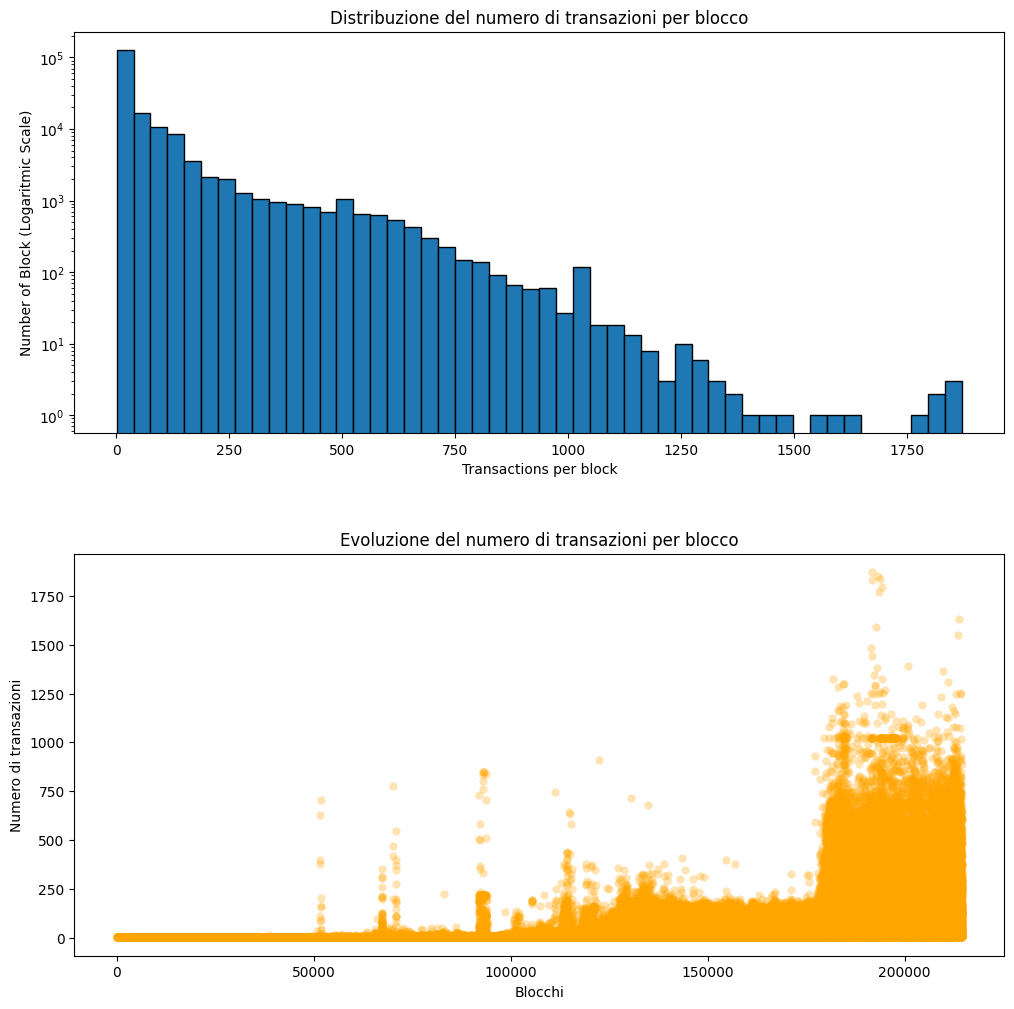

In [5]:
transactionsPerBlock = transactions.groupby('blockId').agg(txCount=('blockId', 'size'), timestamp=('timestamp', 'first')).reset_index()

print(f"Data Frame con Numero di transaziioni per blocco: \n {transactionsPerBlock} \n")

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=.3)

ax = fig.add_subplot(2, 1, 1)
ax.set_yscale('log')

ax.set_title("Distribuzione del numero di transazioni per blocco")
ax.set_xlabel("Transactions per block")
ax.set_ylabel("Number of Block (Logaritmic Scale)")

ax.hist(data = transactionsPerBlock[['txCount']], x='txCount',  bins=50, edgecolor='black')

ax2 = fig.add_subplot(2, 1, 2)

ax2.set_title("Evoluzione del numero di transazioni per blocco")
ax2.set_xlabel("Blocchi")
ax2.set_ylabel("Numero di transazioni")

sns.scatterplot(ax = ax2, data = transactionsPerBlock[['blockId', 'txCount']], x = 'blockId', y = 'txCount', color='orange', linewidth=0, alpha=.3)

plt.show()

Per calcolare la distribuzione del numero di transazioni per blocco durante tutto il periodo temporale, faccio una groupby su transactions considerando il blockId; poi, aggrego i dati calcolando quante transazioni ci sono in ogni gruppo e assegnandogli il timestamp corrispondente, ovvero la data di creazione del blocco.
<br>
Tramite due grafici visualizzo la distribuzione del numero di transazioni per blocco; essendo un dataset che copre un periodo temporale giovane della blockchain, come ci aspettiamo abbiamo un elevato numero di blocchi con poche transazioni.
Nel secondo grafico invece facciamo vedere come varia il numero ti transazioni per blocco con il passare del tempo: considerando tutto l'arco temporale 2009-2012,  con il passare del tempo, coerentemente con quello che ci aspettiamo, il numero di transazioni per blocco aumenta, anche se non linearmente o in modo omogeneo. 

2.2) Evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due mesi

    timestamp  meanTxCount
0  2009-01-31     1.024658
1  2009-03-31     1.018233
2  2009-05-31     1.006549
3  2009-07-31     1.004858
4  2009-09-30     1.005344
5  2009-11-30     1.006669
6  2010-01-31     1.009868
7  2010-03-31     1.033346
8  2010-05-31     1.587792
9  2010-07-31     2.771040
10 2010-09-30     2.246436
11 2010-11-30     7.049851
12 2011-01-31     4.887132
13 2011-03-31    12.599125
14 2011-05-31    17.790306
15 2011-07-31    52.341719
16 2011-09-30    50.522860
17 2011-11-30    42.823209
18 2012-01-31    39.905124
19 2012-03-31    46.008048
20 2012-05-31   102.826678
21 2012-07-31   202.722192
22 2012-09-30   213.586495
23 2012-11-30   208.094642
24 2013-01-31   271.972684


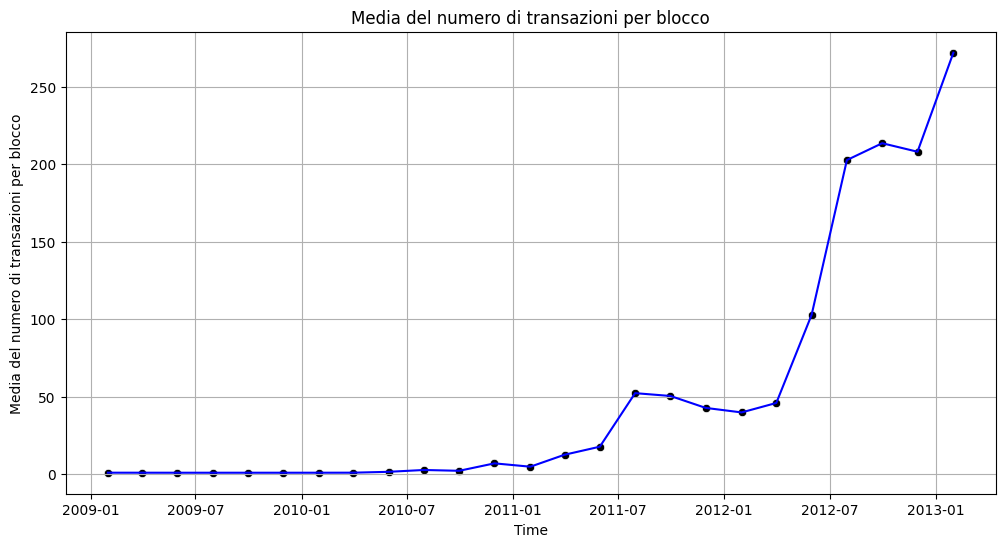

In [6]:
twoMonthsBlockTransactions = transactionsPerBlock[['timestamp', 'txCount']].groupby(pd.Grouper(key='timestamp', freq='2M')).mean().reset_index()
twoMonthsBlockTransactions.rename(columns={'txCount': 'meanTxCount'}, inplace=True)

print(twoMonthsBlockTransactions)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("Media del numero di transazioni per blocco")
ax.set_xlabel("Time")
ax.set_ylabel("Media del numero di transazioni per blocco")
ax.grid(True)
sns.lineplot(data = twoMonthsBlockTransactions[['timestamp', 'meanTxCount']], x = 'timestamp', y = 'meanTxCount', color='blue')
sns.scatterplot(data = twoMonthsBlockTransactions[['timestamp', 'meanTxCount']], x = 'timestamp', y = 'meanTxCount', color='black')

plt.show()

Per calcolare il numero medio di transazioni per blocco ogni due mesi, faccio una groupby sul dataframe transactionPerBlock, considerando però solo le series timestamp e txCount; la groupby viene fatta utilizzando la funzione pandas grouper, che mi permette di raggruppare tutte le righe in gruppi che rappresentano un intervallo temporale di due mesi. Una volta fatto questo calcolo la media su ogni gruppo.
<br>
Rappresento poi il dataframe con un lineplot (sarebbe stato possibile visualizzare i dati anche con un diagramma a barre, ma in questo modo la crescita della media del numero di transazioni per blocco è messa più in evidenza).
Possiamo notare come ci mostrano anche le due precedenti analisi, che il numero medio di transazioni per blocco con il passare del tempo aumenta, ad indicare un numero maggiore di transazioni in ogni blocco.

2.3) Calcolare l'ammontare totale degli UTXO al momento dell'ultima transazione registrata nella blockchain considerata

In [6]:
utxo = pd.DataFrame(columns=outputs.columns)

inputOutput = outputs.merge(inputs, left_on=['txId', 'position'], right_on=['prevTxId', 'prevTxPos'], how='left', indicator=True)

utxo = inputOutput[inputOutput['_merge'] == 'left_only'].drop(columns=['prevTxId', 'prevTxPos', '_merge', 'txId_y', 'addressId', 'scripttype'])
print(utxo)

utxoAmount = utxo['amount'].sum()
print(f"\nL'ammontare totale degli utxo al 31/12/2012 è pari a {utxoAmount} satoshi ovvero %.f bitcoin \n" % (utxoAmount / 1000000))

            txId_x  position      amount
4              183         0  1000000000
11             227         0   100000000
14             255         1  1800000000
41             504         0  6100000000
48             533         1  2500000000
...            ...       ...         ...
24573066  10572825         0           1
24573067  10572825         1     9899999
24573068  10572826         0    26651306
24573069  10572826         1  7991620447
24573070  10572826         2  7991620447

[3194301 rows x 3 columns]

L'ammontare totale degli utxo al 31/12/2012 è pari a 859303372614879 satoshi ovvero 859303373 bitcoin 



Per calcolare l'ammontare totale degli UTXO al momento dell'ultima transazione, per prima cosa devo individuare gli UTXO: per farlo eseguo una merge tra i dataFrame outputs e inputs; questo mi permette, infatti, di associare agli output gli input in cui vengono spesi, scegliendo come colonne comuni rispettivamente (txId, prevTxId) e (position, prevTxPos), in modo da associare ad ogni output l'input in cui è stato speso.
<br>
Per trovare poi gli output non spesi, controllo quali entry del dataframe hanno come valore dell'indicatore (_merge) 'left_only'; questo indicatore, infatti, segnala che i valori di quella entry si trovavano solo nel dataframe outputs e che non vi è stata corrispondenza nel dataframe inputs durante la merge. Questa è l'esatta definizione di utxo, scelgo infatti quelle transazioni in output che non compaiono come input.
<br>
Per calcolare l'ammontare totale seleziono semplicemente la colonna amount e vi calcolo sopra la funzione sum.

2.4) Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output e quella che lo consuma, per gli output spesi nel periodo considerato

              txId            life            creation
0                9 2 days 23:35:46 2009-01-09 03:54:39
1               78 1 days 05:01:19 2009-01-11 01:00:54
2              171 0 days 02:41:51 2009-01-12 03:30:25
3              171 0 days 03:03:57 2009-01-12 03:30:25
4              183 0 days 01:14:27 2009-01-12 06:02:13
...            ...             ...                 ...
21378765  10572820 0 days 00:00:00 2012-12-31 23:52:37
21378766  10572820 0 days 00:00:00 2012-12-31 23:52:37
21378767  10572820 0 days 00:00:00 2012-12-31 23:52:37
21378768  10572820 0 days 00:00:00 2012-12-31 23:52:37
21378769  10572820 0 days 00:00:00 2012-12-31 23:52:37

[21378770 rows x 3 columns]


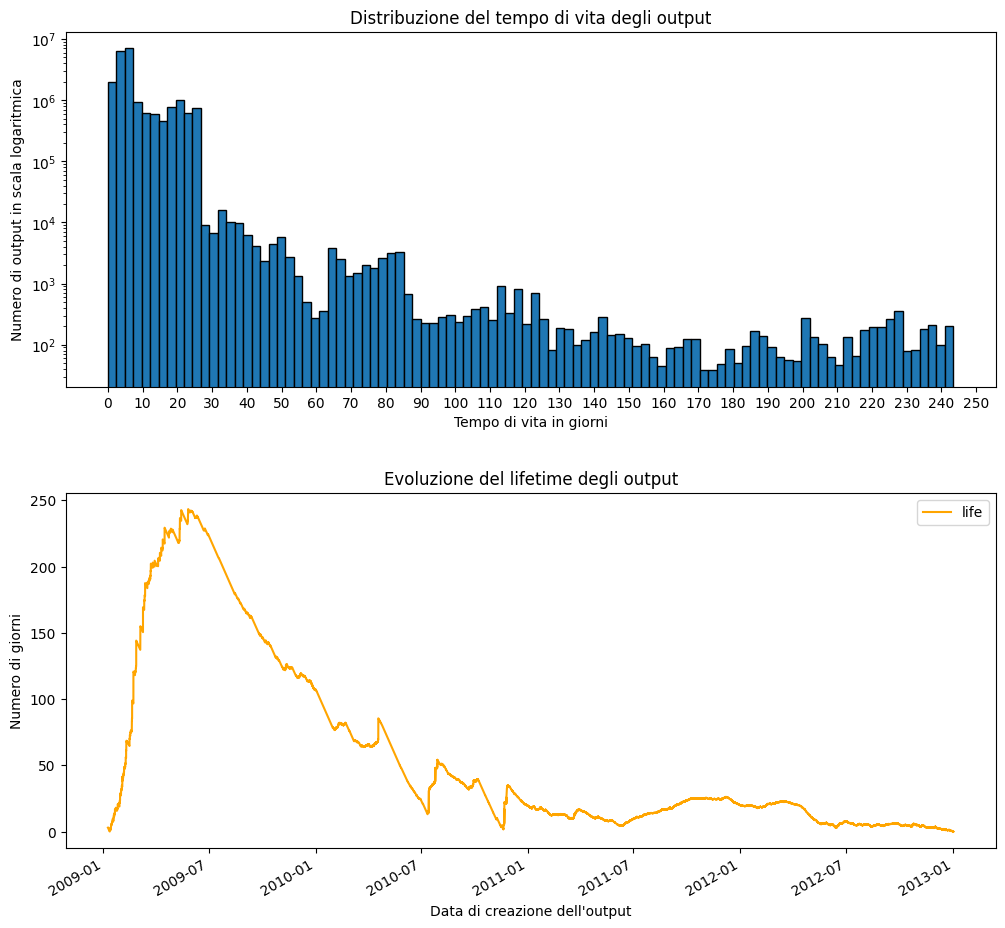

In [7]:
nonUtxo = inputOutput[inputOutput['_merge'] == 'both'].drop(columns=['prevTxId', 'prevTxPos', '_merge', 'scripttype']).rename(columns={'txId_x':'txId'})

timeCreate = nonUtxo[['txId', 'position', 'amount']].merge(transactions[['txId', 'timestamp']], on='txId', how='left')
timeCreate.rename(columns={'timestamp':'Creation'}, inplace=True)

timeSpent = inputs.merge(transactions[['txId', 'timestamp']], on='txId', how='left')
timeSpent.rename(columns={'timestamp':'Spent'}, inplace=True)
timeSpent.sort_values(by=['prevTxId', 'prevTxPos'], inplace=True, ascending=True)

lifetime = pd.DataFrame(columns=['txId', 'life'])
lifetime['txId'] = timeCreate['txId']
lifetime['creation'] = timeCreate['Creation']
lifetime['life'] = timeSpent['Spent'] - timeCreate['Creation']
print(lifetime)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=.3)

ax = fig.add_subplot(2, 1, 1)

ax.set_title('Distribuzione del tempo di vita degli output')
ax.set_xlabel('Tempo di vita in giorni')
ax.set_ylabel('Numero di output in scala logaritmica')
ax.set_yscale('log')
ax.set_xticks(range(0, 270, 10))

lifetime['life'] = lifetime['life'].dt.total_seconds() / 3600 / 24
ax.hist(data = lifetime[['life']], x = 'life', bins = 100, edgecolor='black')


ax2 = fig.add_subplot(2, 1, 2)

ax2.set_title("Evoluzione del lifetime degli output")
ax2.set_ylabel("Numero di giorni")

lifetime.plot(ax=ax2, x='creation', y='life', color='orange', xlabel="Data di creazione dell'output")

plt.show()

Per calcolare la distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output e quella che lo consuma, devo considerare i non UTXO, ovvero le transazioni che vengono effettivamente utilizzate come input; per farlo considero il dataframe ottenuto precedentemente con la merge (inputOutput), che ad ogni transazione in output associa la transazione (input) in cui viene speso, se esiste.
<br>
<br>
A partire da questo dataframe, lo filtro ottenendo solo le entry in cui abbiamo effettivamente avuto una corrispondenza tra output e input, (che corrispondono quindi agli output spesi). Ottenuto il dataframe dei non UTXO, faccio una merge con il dataframe transactions su txId (che è l'id della transazione in cui viene creato quell'output), in modo da ottenere i timestamp che corrispondono alla data di creazione dell'output.
<br>
Per ottenere il dataframe con le date di spesa degli output, faccio una merge tra il dataframe inputs e transactions in modo da aggiungere i timestamp.
<br>
Faccio poi un sort basandomi su prevTxid e prevTxPos che indicano da quale transazione provengono quegli input, in modo da allineare le entry del dataframe timeSpent a quelle del dataframe timeCreate.
<br>
<br>
Adesso che ho due dataframe con tutte le transazioni in output e la loro data di creazione, e lo stesso per gli input (allineati con gli output), posso fare semplicemente una sottrazione tra le colonne timestamp di input e output per ottenere il tempo di vita di ogni output.
<br>
<br>
Visualizzo poi i dati tramite due grafici: con un istogramma la distribuzione dei tempi di vita e con un grafico cartesiano la loro evoluzione.
<br>
Si può notare dall'istogramma che il tempo di vita della maggior parte degli output varia tra 0 e 27 giorni.
<br>
Dal grafico cartesiano si nota che agli inizi della blockchain il tempo di vita era più alto, andando avanti nel tempo invece coerentemente con quanto ci si aspetta il tempo di vita si abbassa, questo è riconducibile ad una maggiore attività sulla blockchain ovvero ad un maggior numero di transazioni che vengono generate da utenti diversi per scopi diversi.

2.5) Correlazione tra fee e valore della transazione, fee e numero di input, numero di input e amount

              txId  fee      amount  inputCount
0              171  0.0   5000.0000           1
1              183  0.0   4000.0000           1
2              185  0.0   3000.0000           1
3              187  0.0   2900.0000           1
4              192  0.0    100.0000           1
...            ...  ...         ...         ...
10358261  10572822  0.1     10.0000           1
10358262  10572823  0.1     10.0000           1
10358263  10572824  0.1     10.0000           1
10358264  10572825  0.1     10.0000           1
10358265  10572826  0.1  16009.9922           2

[10358266 rows x 4 columns]


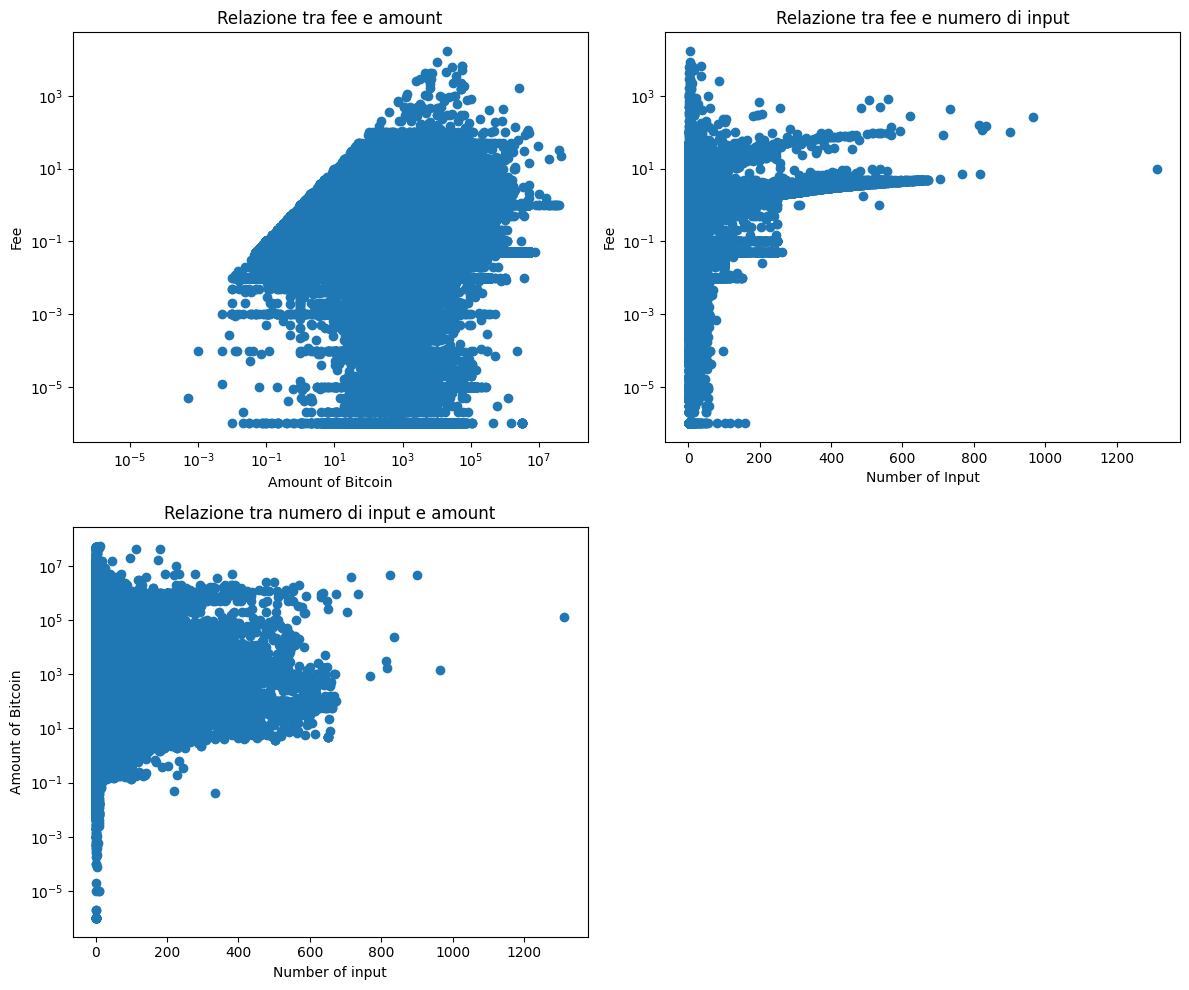

In [8]:
transactionsInfo = inputs[['txId', 'prevTxId', 'prevTxPos']].merge(transactions[['txId', 'fee']][transactions.isCoinbase == 0], on='txId', how='inner')

values = transactionsInfo.merge(nonUtxo[['txId', 'position', 'amount']], left_on=['prevTxId', 'prevTxPos'], right_on=['txId', 'position'], how='inner')
values.drop(columns=['prevTxId', 'prevTxPos', 'txId_y', 'position'], inplace=True)
values.rename(columns={'txId_x':'txId'}, inplace=True)
values['inputCount'] = 1

groupedTx = values.groupby('txId').agg({'fee': 'first', 'amount': 'sum', 'inputCount': 'sum'}).reset_index()
groupedTx['amount'] = groupedTx['amount'] / 1000000
groupedTx['fee'] = groupedTx['fee'] / 1000000
print(groupedTx)


fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].set_title('Relazione tra fee e amount')
ax[0, 0].set_ylabel('Fee')
ax[0, 0].set_xlabel('Amount of Bitcoin')
ax[0, 0].set_yscale('log')
ax[0, 0].set_xscale('log')
ax[0, 0].scatter(data=groupedTx, x='amount', y='fee')

ax[0, 1].set_title('Relazione tra fee e numero di input')
ax[0, 1].set_ylabel('Fee')
ax[0, 1].set_xlabel('Number of Input')
ax[0, 1].set_yscale('log')
ax[0, 1].scatter(data=groupedTx, x='inputCount', y='fee')

ax[1, 0].set_title('Relazione tra numero di input e amount')
ax[1, 0].set_ylabel('Amount of Bitcoin')
ax[1, 0].set_xlabel('Number of input')
ax[1, 0].set_yscale('log')
ax[1, 0].scatter(data=groupedTx, x='inputCount', y='amount')

ax[1, 1].set_visible(False)

plt.tight_layout()

plt.show()

Provo a vedere tramite grafici se ci sono delle correlazioni tra:
<ul>
<li>fee e valore della transazione</li>
<li>fee e numero di input</li>
<li>numero di input e amount</li>
</ul>

<br>

Per farlo creo un dataframe value che conterrà tutte le informazioni (amount, fee e numero di input per ogni transazione): per prima cosa faccio una merge tra inputs e transactions per associare ad ogni transazione gli input e le fee corrispondenti; in questa merge escludo le transazioni che sono coinbase, in quanto non hanno input che provengono da altre transazioni.
<br>
Per associare l'amount corrispondente ad ogni input della transazione, sfrutto il dataframe nonUtxo che mi ero già ricavato; effettuo, quindi, una merge tra value e nonUtxo per aggiungere la series amount, in modo da avere per ogni input il valore corrispondente.
<br>
<br>
Aggiungo una colonna inputCount, che mi servirà per contare quanti input sono presenti in ogni transazione.
<br>
Eseguo poi una groupBy su txId aggregando i dati che ho preparato fin'ora; in particolare, per ogni gruppo prendo la prima fee, in quanto è unica per ogni transazione, e poi la somma degli amount e degli input, in modo da ottenere per ogni transazione le fee, l'amount e il numero di input.
<br>
<br>
Visualizzo poi i dati ottenuti con degli scatter plot e noto che in tutti e 3 i casi i dati risultano essere scorrelati.
<br>
I grafici sono rappresentati in scala logaritmica per avere risultati significativi, anche se i dati risultano scorrelati si nota che:
<ul>
<li>Nel primo grafico come ci si aspetta, l'amount di bitcoin della transazione è sempre inferiore alla fee.</li>
<li>Nel secondo grafico (quello in alto a destra) per grandi input non si hanno fee particolarmente basse.</li>
<li>Nel terzo grafico si nota che per grandi input (> 800) si hanno amount maggiori di 1000 bitcoin per transazione.</li>
</ul>


2.6) Distribuzione e andamento della quantità di bitcoin per transazione spesi nel tempo

              txId      amount           timestamp
0              171   5000.0000 2009-01-12 03:30:25
1              183   4000.0000 2009-01-12 06:02:13
2              185   3000.0000 2009-01-12 06:12:16
3              187   2900.0000 2009-01-12 06:34:22
4              192    100.0000 2009-01-12 07:16:40
...            ...         ...                 ...
10358261  10572822      9.9000 2012-12-31 23:52:37
10358262  10572823      9.9000 2012-12-31 23:52:37
10358263  10572824      9.9000 2012-12-31 23:52:37
10358264  10572825      9.9000 2012-12-31 23:52:37
10358265  10572826  16009.8922 2012-12-31 23:52:37

[10358266 rows x 3 columns]

 La media del numero di bitcoin in output per transazione è 11940.604132913053


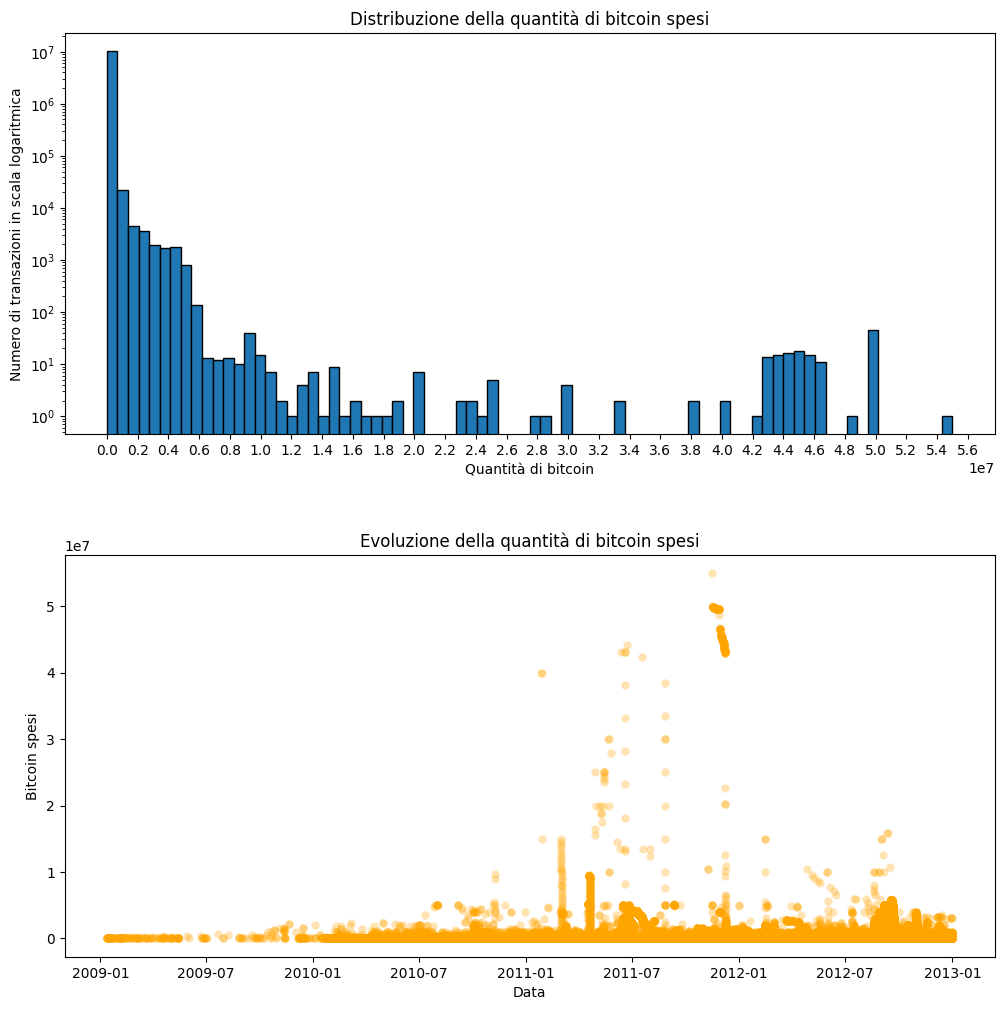

In [9]:
bitcoinAmount = outputs[['txId', 'amount']].merge(transactions[['txId', 'timestamp']][transactions.isCoinbase == 0], on='txId', how='inner')
bitcoinAmount = bitcoinAmount.groupby('txId').agg({'amount':'sum', 'timestamp':'first'}).reset_index()
bitcoinAmount['amount'] = bitcoinAmount['amount'] / 1000000
print(bitcoinAmount)

print(f"\n La media del numero di bitcoin in output per transazione è {bitcoinAmount['amount'].mean()}")

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=.3)

ax = fig.add_subplot(2, 1, 1)

ax.set_title('Distribuzione della quantità di bitcoin spesi')
ax.set_xlabel('Quantità di bitcoin')
ax.set_ylabel('Numero di transazioni in scala logaritmica')
ax.set_yscale('log')
ax.set_xticks(np.arange(0, 6e7, 0.2e7))

ax.hist(data = bitcoinAmount, x = 'amount', bins = 80, edgecolor='black')

ax2 = fig.add_subplot(2, 1, 2)

ax2.set_title("Evoluzione della quantità di bitcoin spesi")
ax2.set_ylabel("Bitcoin spesi")
ax2.set_xlabel("Data")

ax2.scatter(bitcoinAmount['timestamp'], bitcoinAmount['amount'], color='orange', linewidths=0, alpha=0.3)

plt.show()

Analizzo la distribuzione e l'andamento della quantità di bitcoin per transazione spesi nel tempo; per farlo faccio una merge tra i dataframe output e transactions (escludendo le coinbase, in quanto non sono veri bitcoin spesi ma sono guadagni), in modo da avere i timestamp legati agli output; dopodichè faccio una groupby su txId, in quanto per ogni transazione possono esserci diversi output. Aggrego i dati e per ogni gruppo calcolo la somma degli amount che corrisponde al totale speso per quella transazione e la data; infine, divido la series "amount" per 1.000.000 in modo da visualizzare i bitcoin e non i satoshi della transazione.
<br>
<br>
Utilizzo un istogramma per visualizzare la distribuzione della quantità di bitcoin spesi e uno scatter plot per il loro andamento.
<br>
Essendo un dataset che riguarda una porzione giovane della blockchain il numero medio di bitcoin in output per transazione è dell'ordine di decine di migliaia, in particolare il numero medio è 11940. Anche se come possiamo vedere dall'istogramma il maggior numero di transazioni

<h3>3.0) Clusterizzazione degli indirizzi </h3>

In [10]:
nonUtxo['txId_y'] = nonUtxo['txId_y'].astype(int)
transactionsAddress = nonUtxo[['txId', 'position', 'addressId', 'txId_y']].rename(columns={'txId':'inputId', 'txId_y':'txId'})
transactionsAddress = transactionsAddress.merge(mapping, on='addressId', how='left')

g = nx.DiGraph()

def createGraph(transactionsAddress, g):
    g.add_nodes_from(transactionsAddress['hash'])

    groupedAddress = transactionsAddress.groupby('txId')

    for txId, group in groupedAddress:
        if len(group) > 1:
            n = group['hash'].iloc[0]
            
            for m in group['hash'].iloc[1:]:
                g.add_edge(n, m)


createGraph(transactionsAddress, g)

Per clusterizzare gli indirizzi seguiamo un'euristica definita come multi-input: essa consiste nel considerare tutte le transazioni che hanno più di un input (ovvero più di un address come input) e associare allo stesso cluster tutti gli indirizzi usati come input per quella transazione. Inoltre, la procedura di clustering degli indirizzi consente la fusione di indirizzi in input provenienti da transazioni diverse; infatti, se c'è un indirizzo comune in due cluster diversi, questi due cluster devono essere controllati dallo stesso utente; questo perché un indirizzo comune può appartenere solo ad un utente e quindi vengono fusi.
<br>
<br>
Per implementare quest'euristica, innanzitutto seleziono gli indirizzi che compaiono effettivamente come input in delle transazioni, quindi considero le transazioni non UTXO; una volta fatto questo, faccio una merge con il dataframe mapping per associare ad ogni addressId il suo vero hash.
<br>
<br>
Per implementare algoritmicamente quest'euristica si utilizza un grafo: procedo ad aggiungere tutti gli hash (non UTXO) come nodi del grafo e ottengo poi gli insiemi di input di ogni transazione facedo una groupby su txId; una volta fatto questo itero sui gruppi: se il gruppo contiene più di un indirizzo, allora seleziono il primo elemento (indirizzo) e aggiungo un arco tra questo indirizzo e tutti gli altri indirizzi del gruppo; se invece il gruppo contiene un solo indirizzo, vado avanti come descritto dall'euristica.
<br>
<br>
Procedo qua sotto a calcolare effettivamente i cluster sfruttando le componenti debolmente connesse. Avendo aggiunto un arco tra tutti gli input comuni ad una transazione e avendolo fatto per tutte le transazioni; calcolando le componenti debolmente connesse calcolo quali sono i percorsi che da ogni nodo (input) portano ad un altro; questo permette di aggregare gli input che sono collegati (e quindi correlati) tra loro, ottenendo i cluster.

In [11]:
comp = nx.weakly_connected_components(g)
componentsLength = [ len(e) for e in sorted(comp, key=len, reverse=True) ]

largest_cc = componentsLength[0]
mean_cc = np.mean(componentsLength)
smallest_cc = componentsLength[len(componentsLength)-1]

print(f"La dimensione del cluster più grande è {largest_cc}\n")
print(f"La dimensione media dei cluster è {mean_cc}\n")
print(f"La dimensione del cluster più piccolo è {smallest_cc}\n")
print(f"Il numero di cluster è {len(componentsLength)}\n")
print(f"Il coefficiente di clustering è {nx.average_clustering(g)}\n")
print(f"La densità del grafo è {nx.density(g)}\n")

La dimensione del cluster più grande è 259773

La dimensione media dei cluster è 1.9765781096168358

La dimensione del cluster più piccolo è 1

Il numero di cluster è 4001940

Il coefficiente di clustering è 0.0055750770785568515

La densità del grafo è 7.64252689927229e-08



Qua visualizzo alcune proprietà dei cluster quali: dimensione del cluster più grande, dimensione media, dimensione del cluster più piccolo e numero dei cluster.
Calcolo inoltre il coefficiente medio di clustering e la densità del grafo.

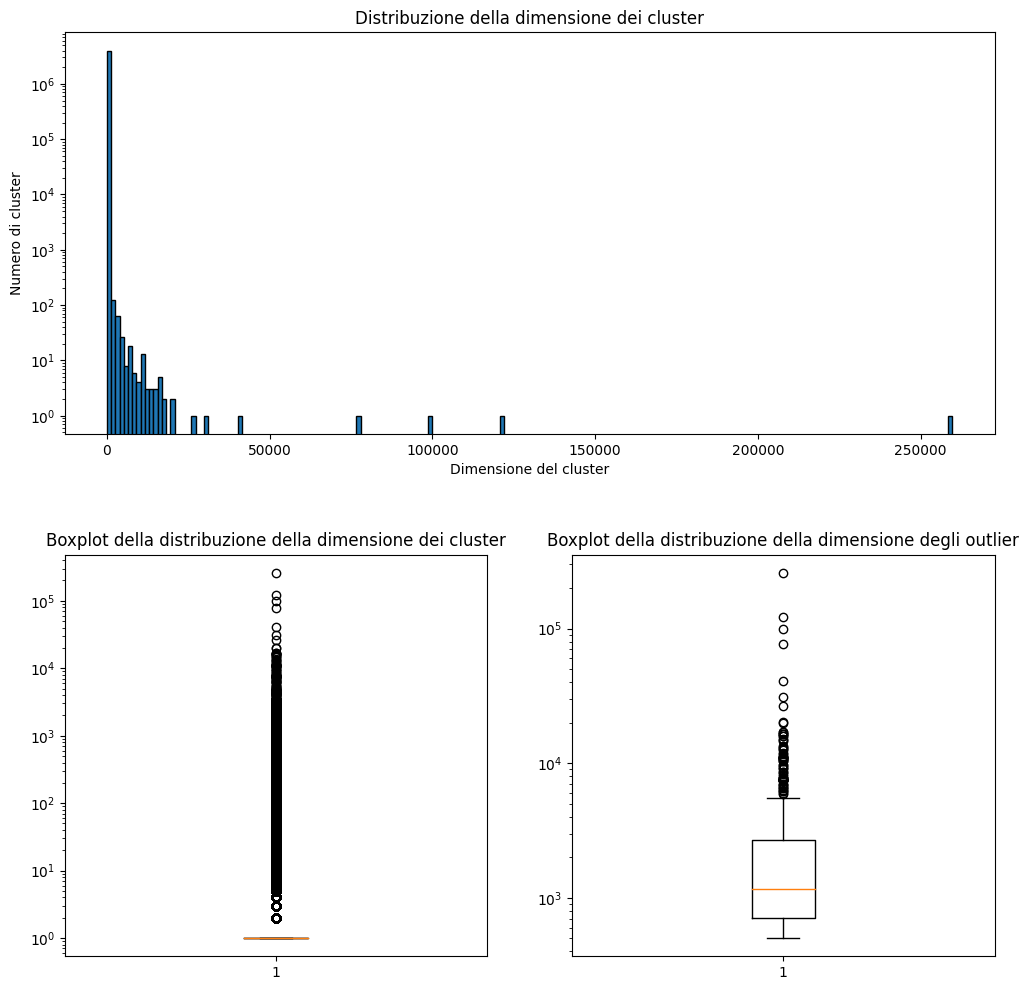

In [12]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=.3)

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Distribuzione della dimensione dei cluster')
ax1.set_xlabel('Dimensione del cluster')
ax1.set_ylabel('Numero di cluster')
ax1.set_yscale('log')
ax1.hist(componentsLength, bins = 200, edgecolor='black')

ax2 = fig.add_subplot(2, 2, 3)
ax2.set_title('Boxplot della distribuzione della dimensione dei cluster')
ax2.set_yscale('log')
ax2.boxplot(componentsLength)

std_cc = np.std(componentsLength)
outlier = [e for e in componentsLength if e > mean_cc+3*std_cc]

ax3 = fig.add_subplot(2, 2, 4)
ax3.set_title('Boxplot della distribuzione della dimensione degli outlier')
ax3.set_yscale('log')
ax3.boxplot(outlier)

plt.show()



Visualizzo tramite dei grafici alcune caratteristiche dei cluster; in particolare con un istogramma e un boxplot visualizzo la distribuzione della grandezza dei cluster. 
<br>
Coerentemente con quanto ci si aspetta la maggior parte dei cluster è di piccola dimensione, rappresentano infatti le transazioni dei singoli utenti e non di servizi che operano sulla blockchain.
<br>
<br>
Possiamo notare che ci sono molti dati così definiti outlier, ovvero che si discostano molto dalla media della distribuzione, che come abbiamo visto sopra è circa 1,9765. Dato che il primo boxplot a causa degli outlier non è significativo con un altro boxplot visualizzo la loro distribuzione.
<br>
Per outlier considero i dati tali per cui:   $ \text{dato} > ( media + 3 * dev_{std} )$
<br>
<br>
Gli outlier sono i cluster di interesse, sono infatti quelli che contengono il maggior numero di indirizzi, di conseguenza probabilmente la deanonimizzazione sarà più semplice e potremo scoprire quali wallet vi sono associati.

<h3>4.0) Deanonimizzazione degli indirizzi </h3>

4.1) Calcolo dei 10 cluster più numerosi

In [13]:
comp = nx.weakly_connected_components(g)

majorClusters = [(cluster_id, data) for cluster_id, data in enumerate(comp)]
majorClusters = sorted(majorClusters, key=lambda x: len(x[1]), reverse=True)[:10]

topTenCluster = {}

for cluster_id, cluster_data in majorClusters:
    topTenCluster[cluster_id] = cluster_data

topTenClusterKeys = list(topTenCluster.keys())
print(f"Questi sono i cluster_id dei 10 cluster più numerosi in senso decrescente \n {topTenClusterKeys}")

Questi sono i cluster_id dei 10 cluster più numerosi in senso decrescente 
 [43432, 2034234, 495767, 248550, 1052450, 860566, 2225168, 1018450, 1730198, 1982259]


Calcolo i 10 cluster più numerosi, li ordino in senso decrescente e mi creo un dizionario che associ ad ogni cluster_id l'array contente gli indirizzi appartenenti al cluster.

4.2) Scraping degli indirizzi su walletExplorer e bitInfoChart

In [17]:
def checkResponse(response):
    if response.status_code == 429: 
        return False
    elif response.status_code != 200:
        response.raise_for_status()
    
def getProxy(obtainedProxy):
    proxy = {}
    proxy['http'] = FreeProxy().get()

    while(proxy['http'] in obtainedProxy):
        proxy['http'] = FreeProxy().get()
    
    obtainedProxy.add(proxy['http'])

    pass
    return proxy

def searchProxy(obtainedProxy):
    with ThreadPoolExecutor() as executor:
        future = executor.submit(getProxy, obtainedProxy)
        return future.result(timeout=90)

def findWalletExplorerService(url, address, cont, proxySet):
    payload = {'q': address}

    if cont % 15 == 0:
        proxy = searchProxy(proxySet)

    response = requests.get(url, params = payload, proxies = None if cont % 15 != 0 else proxy)
    
    while(checkResponse(response) == False):
        time.sleep(15)
        
        proxy = searchProxy(proxySet)

        response = requests.get(url, params = payload, proxies =  proxy)

    soup = BeautifulSoup(response.content, 'html.parser')
    service = soup.find('h2').contents[2]

    if(service[0] != '['): return service
    else: return "No service found"


def findBitInfoChartService(url, address, proxySet):
    header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 ' + ' (KHTML, like Gecko) Chrome/61.0.3163.100Safari/537.36'}


    response = requests.get((url+address), headers=header)

    while(checkResponse(response) == False):
        proxy = searchProxy(proxySet)
        
        response = requests.get((url+address), headers=header, proxies =  proxy)

    soup = BeautifulSoup(response.content, 'html.parser')

    result = soup.find('a', attrs={'style':"color: #018174"})

    service = result.text[8:] if result != None else "No service found"
    service = service if service.isdigit() != True else "No service found"
    
    return service


def assignService(topClusters, select, addressNum=50):
    topCluster = topClusters
    cluster_Id = list(topCluster.keys())
    services = {}
    clusterIndex = 0
    scanned = 0
    proxySet = set()

    while ((len(cluster_Id) != 0) & (scanned < addressNum)):
        random.seed(2+scanned%4)
        cluster_data = list(topCluster[cluster_Id[clusterIndex]])
        random.shuffle(cluster_data)
        cont = 1
        while cont%6 != 0:
            scanned+=1

            if select == 0:
                try:
                    service = findWalletExplorerService('https://www.walletexplorer.com/', cluster_data[0], scanned, proxySet)
                except TimeoutError:
                    print("Esecuzione terminata a causa di un errore nella ricerca del proxy")
                    return services
                except Exception as e:
                    print("Errore nella richiesta al sito", e)
                    return services
                
            else:
                try:
                    service = findBitInfoChartService('https://bitinfocharts.com/bitcoin/address/', cluster_data[0], proxySet)
                except TimeoutError:
                    print("Esecuzione terminata a causa di un errore nella ricerca del proxy")
                    return services
                except Exception as e:
                    print("Errore nella richiesta al sito", e)
                    return services
            
            cont+=1
            del cluster_data[0]

            if service != "No service found":
                services[cluster_Id[clusterIndex]] = service
                print(f"Cluster {cluster_Id[clusterIndex]} deanonimizzato, è stato associato il wallet "f"{services[cluster_Id[clusterIndex]]}\n")
                del cluster_Id[clusterIndex]
                break
        
        clusterIndex = clusterIndex + 1 if (clusterIndex < len(cluster_Id)-1) else 0

    return services

Funzione assignService()
<br>
Per la parte di scraping degli indirizzi utilizzo la funzione assignService; questa funzione prende 3 parametri:
<ul>
<li>topCluster, ovvero il dizionario contenente i 10 cluster più numerosi</li>
<li>select, un valore binario 0 o 1 che seleziona su quale sito fare scraping: 0 = walletEplorer, 1 = bitInfoChart</li>
<li>addressNum, un parametro settato di default a 50 che indica di quanti indirizzi fare lo scraping</li>
</ul>

Nella funzione procedo ad eseguire una copia del dizionario topCluster: in quanto la struttura dati viene passata per riferimento, la funzione la modificherà e non voglio venga modificato l'originale.
<br>
<br>
Definisco poi:
<br>
<ul>
<li>un array cluster_Id che conterrà le chiavi dei 10 cluster più numerosi
<br>
<li>clusterIndex sarà l'indice che itererà sull'array cluster_Id selezionando ad ogni iterazione il cluster da cui prendere gli indirizzi
<br>
<li>scanned è un contatore che terrà traccia del numero di indirizzi su cui abbiamo fatto scraping fino ad ora.
<br>
<li>proxySet è un insieme che servirà alla funzione getProxy() per ricordarsi quali proxy sono già stati usati.
</ul><br>

Il funzionamento dell'algoritmo è il seguente:
<br> 
Il primo ciclo while itera fino a che non è stato scansionato un numero di indirizzi maggiore o uguale ad addressNum, oppure fino a che non sono stati deanonimizzati tutti i cluster.
All'interno di questo ciclo ad ogni iterazione considero un cluster diverso; per prima cosa eseguo uno shuffle dell'array che contiene gli indirizzi del cluster corrente, in modo da massimizzare la casualità della scelta degli indirizzi dal cluster.
<br>
Il secondo ciclo si occupa di scansionare (nel caso peggiore, ovvero quello in cui il cluster non viene deanonimizzato) 6 indirizzi prima di passare al prossimo. Una volta arrivati all'ultimo cluster, se ce ne sono altri da deanonimizzare e non abbiamo raggiunto il numero massimo di indirizzi da cercare, rinizio a scansionare i cluster rimasti in cluster_Id: tratto infatti l'array dei cluster_Id in maniera dinamica e come un array circolare.
Nel secondo ciclo, in base al valore di select, effettuiamo lo scraping dell'indirizzo su walletEplorer o su bitInfoChart; dopo aver fatto lo scraping dell'indirizzo provvedo ad eliminarlo dal cluster in modo che non venga analizzato nuovamente; in seguito, analizzo il risultato dello scraping: se ho trovato il servizio, allora la variabile service sarà diversa dalla stringa "No service found", quindi aggiungerò al dizionario nella chiave corrispondente al cluster_id il wallet trovato; inoltre, eliminerò il cluster_id dall'array contente i cluster_id da scansionare, in quanto posso considerare quel cluster come deanonimizzato.
In questo modo man a mano che deanonimizzo i cluster la dimensione dell'array contente i cluster da scansionare diminuisce.
<br>
<br>

Funzione findWalletEplorerService()
<br>
<br>

Questa funzione prendere 4 argomenti:
<ul>
<li>url: indica il sito web su cui fare scraping, in questo caso walletExplorer</li>
<li>address: indica l'indirizzo da cercare nel sito</li>
<li>cont: indica il numero di indirizzi cercati fino ad ora</li>
<li>proxySet: insieme dei proxy utilizzati</li>
</ul>

<br>
Nella funzione procedo a creare un payload per effettuare una query al sito; se il numero di indirizzi scansionati fino ad ora è multiplo di 15, utilizzo un proxy: questo è necessario in quanto dopo tot richieste il sito blocca l'accesso.
<br>
Procedo poi a fare la richiesta al sito; con la funzione checkResponse controllo lo status della richiesta: se è andata a buon fine, eseguo lo scraping della pagina web andando a cercare il nome del wallet associato, se esiste; se non esiste otterrò un identificatore numerico racchiuso tra quadre, quindi restituirò la stringa "no service found".
<br>
Se la richiesta non è andata a buon fine a causa di un numero elevato di richieste nell'ultimo periodo di tempo, entro nel ciclo while, che farà una sleep di 15 secondi, cercherà un nuovo server proxy da cui connettersi e farà una nuova richiesta.
<br>
Se la ricerca del proxy dovesse impiegare troppo tempo, la funzione searchProxy() lancerà un'eccezione e l'esecuzione terminerà restituendo i wallet trovati fino a quel momento.
<br>
Attraverso la funzione checkResponse, se la richiesta dovesse fallire per motivi diversi dalle troppe richieste, verrà lanciata un'eccezione che terminerà l'esecuzione del programma.
<br>
<br>

Funzione searchProxy()
La funzione prende in input l'insieme dei proxy utilizzati fino ad ora.
Questa funzione non è altro che un wrapper per la funzione getProxy; si è resa necessaria in quanto necessitavo di un timeout per l'esecuzione della funzione getProxy(), questo perché per costruzione potrebbe portare ad attesa indefinita.
<br>
Questa funzione esegue la funzione getProxy() creando un thread e assegnando un tempo di vita a quest'ultimo.
<br>
Se la funzione getProxy() non termina prima del timeout, si solleva un'eccezione che verrà intercettata da un blocco try except nella funzione assignService(); in questo caso la funzione terminerà restituitendo il dizionario con i cluster deanonimizzati fino a questo momento.
<br>
<br>

Funzione getProxy()
<br>
La funzione prende in input l'insieme dei proxy utilizzati fino ad ora.
La funzione cerca dei proxy utilizzabili tramite la funzione di libreria FreeProxy().get(); questa funzione può portare ad attesa indefinita, per questo si è reso necessario l'utilizzo di un timeout per l'esecuzione della funzione. Una volta ottenuto il proxy, all'interno di un while controllo che non sia già stato estratto cercandolo all'interno dell'insieme obtainedProxy; se è un proxy nuovo provvedo ad aggiungercelo e ad utilizzarlo per effettuare nuove richieste al sito.
<br>
<br>

Funzione findBitInfoChartService()
<br>
La funzione prende in input l'url su cui effettuare lo scraping e l'indirizzo da analizzare; successivamente creo un header fittizio per camuffare la richiesta automatica e faccio una get al sito tramite una query.
Analizzo a questo punto la risposta esattamente come facevo con walletExplorer.
<br>
Cerco poi se all'indirizzo è associato un wallet: se il risultato è un valore None associo la stringa No service found, altrimenti assegno una parte della stringa trovata; essa non è però detto che sia il servizio, infatti, come per wallet explorer potrebbe essere una valore numerico. Controllo quindi se la stringa rappresenta un numero, se lo rappresenta, associo "No service found" altrimenti quello è il servizio da associare al cluster.

In [18]:
print("Deanonimizzazione dei cluster usando WalletExplorer:")     
walletExplorer = assignService(topTenCluster, 0)
print(walletExplorer)

Deanonimizzazione dei cluster usando WalletExplorer:
Cluster 43432 deanonimizzato, è stato associato il wallet CoinJoinMess 

Cluster 248550 deanonimizzato, è stato associato il wallet Instawallet.org 

Cluster 860566 deanonimizzato, è stato associato il wallet BTC-e.com-old 

Cluster 2034234 deanonimizzato, è stato associato il wallet SilkRoadMarketplace 

Cluster 2225168 deanonimizzato, è stato associato il wallet BtcDice.com 

{43432: 'CoinJoinMess ', 248550: 'Instawallet.org ', 860566: 'BTC-e.com-old ', 2034234: 'SilkRoadMarketplace ', 2225168: 'BtcDice.com '}


In [16]:
print("\nDeanonimizzazione dei cluster usando bitinfocharts:")
bitinfochart = assignService(topTenCluster, 1, 150)
print(bitinfochart)


Deanonimizzazione dei cluster usando bitinfocharts:
Cluster 43432 deanonimizzato, è stato associato il wallet F2Pool

Cluster 248550 deanonimizzato, è stato associato il wallet Instawallet.org

Cluster 860566 deanonimizzato, è stato associato il wallet Eligius

Cluster 2034234 deanonimizzato, è stato associato il wallet SilkRoadMarketplace

{43432: 'F2Pool', 248550: 'Instawallet.org', 860566: 'Eligius', 2034234: 'SilkRoadMarketplace'}


Riesco in totale a deanonimizzare 5 cluster, 5 con walletExplorer e 4 con bitInfoChart: 
<ul>
<li>walletExplorer: {43432: 'CoinJoinMess ', 248550: 'Instawallet.org ', 860566: 'BTC-e.com-old ', 2034234: 'SilkRoadMarketplace ', 2225168: 'BtcDice.com '}</li>
<li>bitInfoChart: {43432: 'F2Pool', 248550: 'Instawallet.org', 860566: 'Eligius', 2034234: 'SilkRoadMarketplace'}</li>
</ul>
<br>
Si nota che per 2 cluster si ottengono 2 risultati diversi tra lo scraping su walletExplorer e bitInfoChart. Questi risultati contrastanti riguardano i cluster che io identifico come '43432' e '860566'; in particolare walletExplorer assegna a questi due cluster rispettivamente i servizi: 'CoinJoinMess' e 'BTX-e.com-old', mentre bitInfoCharts i wallet: 'F2Pool' ed 'Eligius'.
<br>
<br>
Un possibile motivo per cui vengono associati servizi diversi allo stesso cluster potrebbe essere per via degli algoritmi di clustering utilizzati dai due servizi, in particolare non essendo gli stessi, gli indirizzi potrebbero venir clusterizzati in modo diverso.
<br> 
<br>
Un altro motivo potrebbe essere quello che all'interno di questi cluster vi siano dei falsi positivi che ci portano quindi ad associare servizi diversi.
<br>
<br>
Un'altra possibilità riguarda la tendenza di walletExplorer ad associare indirizzi al cluster di CoinJoinMess, in particolare come spiega questo thread di bitcoinTalk <a href='https://bitcointalk.org/index.php?topic=279249.msg51334236#msg51334236'>https://bitcointalk.org/index.php?topic=279249.msg51334236#msg51334236</a> , a causa di un pagamento coinjoin verso i wallet joinMarket e wasabi adesso walletExplorer clusterizza gli indirizzi coinjoin in un cluster molto grande che prima era identificato come "MtGoxAndOthers" e che adesso viene chiamato "coinJoinMess".
<br>
<br>
CoinJoin è un metodo che permette di rendere ancora più anonime le transazioni aggregando input di utenti diversi in un'unica transazione, questo altera le strategie di deanonimizzazione che sfruttano meccanismi di clustering che si basano su euristiche multi-input come quella da noi utilizzata e che anche walletExplorer utilizza.